In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

In [2]:
annonimized_df = pd.read_csv('./data-tbtl/annonimized.csv')
qt_df = pd.read_csv('./public_it001/qt-public.csv')

In [3]:
annonimized_df.columns = [
    'assignment_id', 'problem_id', 'username', 'is_final', 'status', 
    'pre_score', 'coefficient', 'language_id', 'created_at', 'updated_at', 
    'judgement'
]

In [4]:
qt_df.rename(columns={'hash': 'username'}, inplace=True)
qt_df.head()

,username,diemqt
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,9.0
3,013de369c439ab0ead8aa7da64423aa395a8be39,10.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,9.0


In [5]:
def convert_to_datetime(df, column, formats):
    for fmt in formats:
        try:
            return pd.to_datetime(df[column], format=fmt, errors='coerce')
        except (ValueError, TypeError):
            continue
    raise ValueError(f"Date format in column '{column}' does not match.")

date_formats = ['%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S', '%d-%m-%Y %H:%M:%S']

# Chuyển đổi các cột thời gian sang định dạng datetime
annonimized_df['created_at'] = convert_to_datetime(annonimized_df, 'created_at', date_formats)
annonimized_df['updated_at'] = convert_to_datetime(annonimized_df, 'updated_at', date_formats)

annonimized_df['submission_time'] = (annonimized_df['updated_at'] - annonimized_df['created_at']).dt.total_seconds()
annonimized_df['is_successful'] = annonimized_df['status'].apply(lambda x: 1 if x == 'SCORE' else 0)
annonimized_df.drop(['status', 'created_at', 'updated_at'], axis=1, inplace=True)

In [6]:
import json

def parse_judgement(judgement_str):
    try:
        judgement = json.loads(judgement_str)
        times = judgement.get("times", [])
        mems = judgement.get("mems", [])
        verdicts = judgement.get("verdicts", {})
        
        return pd.Series([sum(times), sum(mems), len(verdicts)], index=['total_time', 'total_mem', 'num_verdicts'])
    except (json.JSONDecodeError, AttributeError):
        return pd.Series([0, 0, 0], index=['total_time', 'total_mem', 'num_verdicts'])

judgement_features = annonimized_df['judgement'].apply(parse_judgement)
annonimized_df = pd.concat([annonimized_df, judgement_features], axis=1)
annonimized_df = annonimized_df.drop(['judgement'], axis=1)

annonimized_df.head()

,assignment_id,problem_id,username,is_final,pre_score,coefficient,language_id,submission_time,is_successful,total_time,total_mem,num_verdicts
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,0,100,it0012,294.0,1,0.0,0.0,1.0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,0,100,it0012,10.0,1,0.0,0.0,1.0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,10000,100,it0012,9.0,1,0.0,0.0,0.0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,10000,100,it0012,9.0,1,0.0,0.0,0.0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,10000,100,it0012,10.0,1,0.0,0.0,0.0


In [7]:
features_df = annonimized_df.groupby('username').agg(
    total_assignments=('assignment_id', 'nunique'),
    total_submissions=('problem_id', 'count'),
    final_submissions=('is_final', lambda x: (x == 1).sum()),
    successful_submissions=('is_successful', 'sum'),
    avg_pre_score=('pre_score', 'mean'),
    avg_submission_time=('submission_time', 'mean'),
    avg_time=('total_time', 'mean'),
    avg_mem=('total_mem', 'mean')
).reset_index()

features_df.head()

,username,total_assignments,total_submissions,final_submissions,successful_submissions,avg_pre_score,avg_submission_time,avg_time,avg_mem
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7,147,46,119,5504.149660,8195.428571,0.322517,2289.850340
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,9,259,78,209,5488.552124,-232304.548263,0.253514,2946.625483
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7,195,67,175,5973.753846,-103020.830769,0.201436,2054.256410
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,4,100,47,76,5952.760000,1514.090000,0.066000,374.480000
4,013de369c439ab0ead8aa7da64423aa395a8be39,8,107,66,94,6474.448598,184.037383,0.743832,4987.813084


In [8]:
scaler = StandardScaler()
columns_to_scale = ['total_assignments', 'total_submissions', 'final_submissions', 'successful_submissions', 'avg_pre_score', 'avg_submission_time', 'avg_time', 'avg_mem']
features_df[columns_to_scale] = scaler.fit_transform(features_df[columns_to_scale])

In [9]:
merged_df = pd.merge(features_df, qt_df, on='username', how='left')
merged_df.head()

,username,total_assignments,total_submissions,final_submissions,successful_submissions,avg_pre_score,avg_submission_time,avg_time,avg_mem,diemqt
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,-0.061584,-0.383787,-0.535003,-0.373568,0.212652,0.368755,-0.138163,-0.183268,7.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,0.468462,0.454887,0.399071,0.484979,0.202299,-1.349050,-0.187932,-0.160966,7.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,-0.061584,-0.024355,0.077983,0.160639,0.524376,-0.425623,-0.225493,-0.191269,9.0
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,-0.856652,-0.735730,-0.505813,-0.783763,0.510440,0.321032,-0.323177,-0.248310,NaN
4,013de369c439ab0ead8aa7da64423aa395a8be39,0.203439,-0.683313,0.048793,-0.612053,0.856738,0.311532,0.165712,-0.091652,10.0


C:\Users\Admin\AppData\Local\Temp\ipykernel_25388\1333519376.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_df.corr()


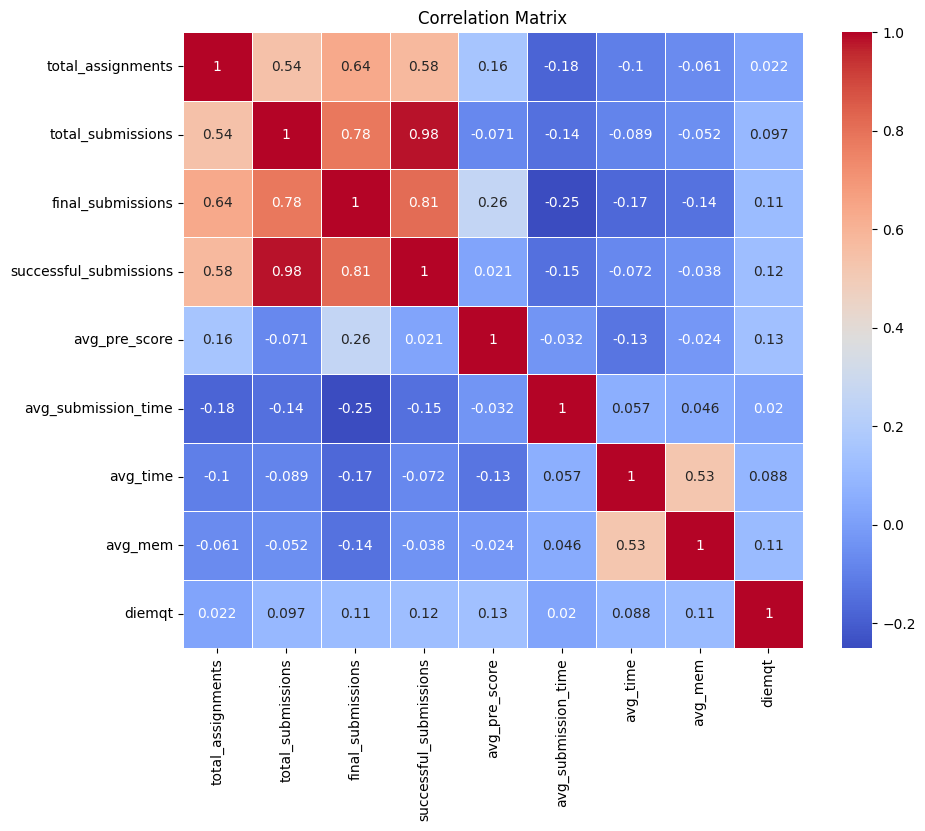

In [10]:
plt.figure(figsize=(10, 8))
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [11]:
train_test_df = merged_df.dropna(subset=['diemqt'])

X = train_test_df.drop(columns=['username', 'diemqt'])
y = train_test_df['diemqt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Tạo mô hình base learners
base_learners = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('cat', CatBoostRegressor(random_state=42, verbose=None)),
    ('knn', KNeighborsRegressor()),
    ('lasso', Lasso(random_state=42)),
    ('ridge', Ridge(random_state=42))
]

# Tạo mô hình meta learner
meta_learner = LinearRegression()

# Tạo mô hình Stacking Regressor
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)

# Huấn luyện mô hình Stacking Regressor
stacking_model.fit(X_train, y_train)

# Dự đoán và đánh giá mô hình Stacking Regressor
y_pred_stacking = stacking_model.predict(X_test)
r2 = r2_score(y_test, y_pred_stacking)
print('R2 score:', r2)

Learning rate set to 0.037798
0:	learn: 1.7791883	total: 148ms	remaining: 2m 27s
1:	learn: 1.7722283	total: 149ms	remaining: 1m 14s
2:	learn: 1.7648187	total: 151ms	remaining: 50.1s
3:	learn: 1.7570592	total: 152ms	remaining: 38s
4:	learn: 1.7516414	total: 154ms	remaining: 30.6s
5:	learn: 1.7438116	total: 155ms	remaining: 25.7s
6:	learn: 1.7373737	total: 158ms	remaining: 22.4s
7:	learn: 1.7295200	total: 159ms	remaining: 19.8s
8:	learn: 1.7220591	total: 161ms	remaining: 17.7s
9:	learn: 1.7164893	total: 163ms	remaining: 16.1s
10:	learn: 1.7100146	total: 164ms	remaining: 14.8s
11:	learn: 1.7056772	total: 166ms	remaining: 13.7s
12:	learn: 1.6986824	total: 167ms	remaining: 12.7s
13:	learn: 1.6947166	total: 169ms	remaining: 11.9s
14:	learn: 1.6887765	total: 170ms	remaining: 11.2s
15:	learn: 1.6853176	total: 172ms	remaining: 10.6s
16:	learn: 1.6809654	total: 174ms	remaining: 10s
17:	learn: 1.6755627	total: 175ms	remaining: 9.57s
18:	learn: 1.6714494	total: 177ms	remaining: 9.14s
19:	learn: 1.

In [13]:
submission_df = merged_df[merged_df['diemqt'].isna()]
X_submission = submission_df.drop(columns=['username', 'diemqt'])
y_submission_pred = stacking_model.predict(X_submission)

submission_df['diemqt'] = y_submission_pred
submission_df = submission_df[['username', 'diemqt']]
submission_df.to_csv('predict_qt.csv', index=False, header=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25388\3586101085.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['diemqt'] = y_submission_pred
